# Progetto Business Intelligence per i Servizi Finanziari (a.a. 2023-2024)
Luca Pinciroli 885969

## 1. Dati utilizzati

Per prima cosa importiamo le librerie che serviranno a compiere tutte le operazioni necessarie.

In [114]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import getFamaFrenchFactors as gff

plt.style.use('default')

Dopodiché creiamo una semplice funzione che consente di scaricare i dati giornalieri di un'azione da Yahoo Finance e salvarli in formato CSV per averli sempre a disposizione.

In [115]:
def prendi_dati_titolo(ticker, start_date, end_date):
    
    data_dir = "StoricoDatiTitoli" # Nome della cartella per i file CSV
    os.makedirs(data_dir, exist_ok=True)
    
    
    csv_file = os.path.join(data_dir, f"{ticker}.csv") # Nome del file CSV basato sul ticker
    
    # Funzione per caricare i dati dal CSV
    def carica_da_csv():
        try:
            df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
            df = df.loc[start_date:end_date]
            return df
        except (FileNotFoundError, pd.errors.EmptyDataError):
            return None
    
    # Funzione per scaricare i dati da Yahoo Finance e salvarli in un CSV
    def scarica_da_yahoo():
        df = yf.download(ticker, start=start_date, end=end_date)
        df.to_csv(csv_file)
        return df
    
    data = carica_da_csv()
    
    if data is None or data.empty:
        data = scarica_da_yahoo()
    
    return data

Scarichiamo i dati dei titoli scelti ed inseriamoli in un DataFrame indicizzato per titolo e data.

In [116]:
# periodo di interesse per tutte le analisi
inizio = dt.datetime(2014, 5, 31)
fine = dt.datetime(2024, 5, 31)

settore_1 = 'Tecnologia elettronica'
settore_2 = 'Vendita al dettaglio'
settore_3 = 'Servizi commerciali'

tickers_settore1 = ['AAPL', 'INTC'] # Tecnologia elettronica
tickers_settore2 = ['AMZN', 'WMT'] # Vendita al dettaglio
tickers_settore3 = ['V', 'MA'] # Servizi commerciali

# Apple, Intel, Amazon, Walmart, Visa, Mastercard
tickers = tickers_settore1 + tickers_settore2 + tickers_settore3
data_frames = []

for ticker in tickers:
    df = prendi_dati_titolo(ticker, inizio, fine)
    df['Ticker'] = ticker
    data_frames.append(df)
    
dataframe_completo = pd.concat(data_frames)
dataframe_completo.set_index(['Ticker', dataframe_completo.index], inplace=True)

dataframe_completo

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
AAPL   2014-06-02   22.641430   22.672501   22.232143   22.451786   19.859398   
       2014-06-03   22.445000   22.812143   22.437500   22.769285   20.140236   
       2014-06-04   22.765715   23.138929   22.718214   23.029285   20.370214   
       2014-06-05   23.078571   23.191786   22.950357   23.119642   20.450140   
       2014-06-06   23.210714   23.259287   23.016787   23.056070   20.393904   
...                       ...         ...         ...         ...         ...   
MA     2024-05-23  456.519989  458.049988  450.440002  451.209991  451.209991   
       2024-05-24  452.510010  454.450012  450.320007  451.179993  451.179993   
       2024-05-28  450.000000  450.630005  442.399994  445.079987  445.079987   
       2024-05-29  442.109985  444.559998  441.799988  442.470001  442.470001   
       2024-05-30  442.209991  444.190002  440.670013  442.100006  442.100006   

                      Volume  
Ticker Date                   
AAPL   2014-06-02  369350800  
       2014-06-03  292709200  
       2014-06-04  335482000  
       2014-06-05  303805600  
       2014-06-06  349938400  
...                      ...  
MA     2024-05-23    2084600  
       2024-05-24    2162100  
       2024-05-28    2670800  
       2024-05-29    1876900  
       2024-05-30    2189900  

[15102 rows x 6 columns]

In [117]:
prezzi_chiusura_giornalieri = dataframe_completo.reset_index().pivot_table(index='Date', columns='Ticker', values='Adj Close', sort=False)
prezzi_chiusura_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-02,19.859398,20.772066,15.442000,20.799509,49.775650,72.443565
2014-06-03,20.140236,21.076870,15.359500,20.785961,49.262760,71.785408
2014-06-04,20.370214,21.031145,15.339000,20.899773,49.288418,71.757202
2014-06-05,20.450140,21.076870,16.178499,20.951252,49.472580,72.246124
2014-06-06,20.393904,21.465481,16.483500,20.921448,49.654419,72.838463
...,...,...,...,...,...,...
2024-05-23,186.880005,30.080000,181.050003,64.839996,274.230011,451.209991
2024-05-24,189.979996,30.719999,180.750000,65.379997,274.489990,451.179993
2024-05-28,189.990005,31.059999,182.149994,65.040001,270.980011,445.079987


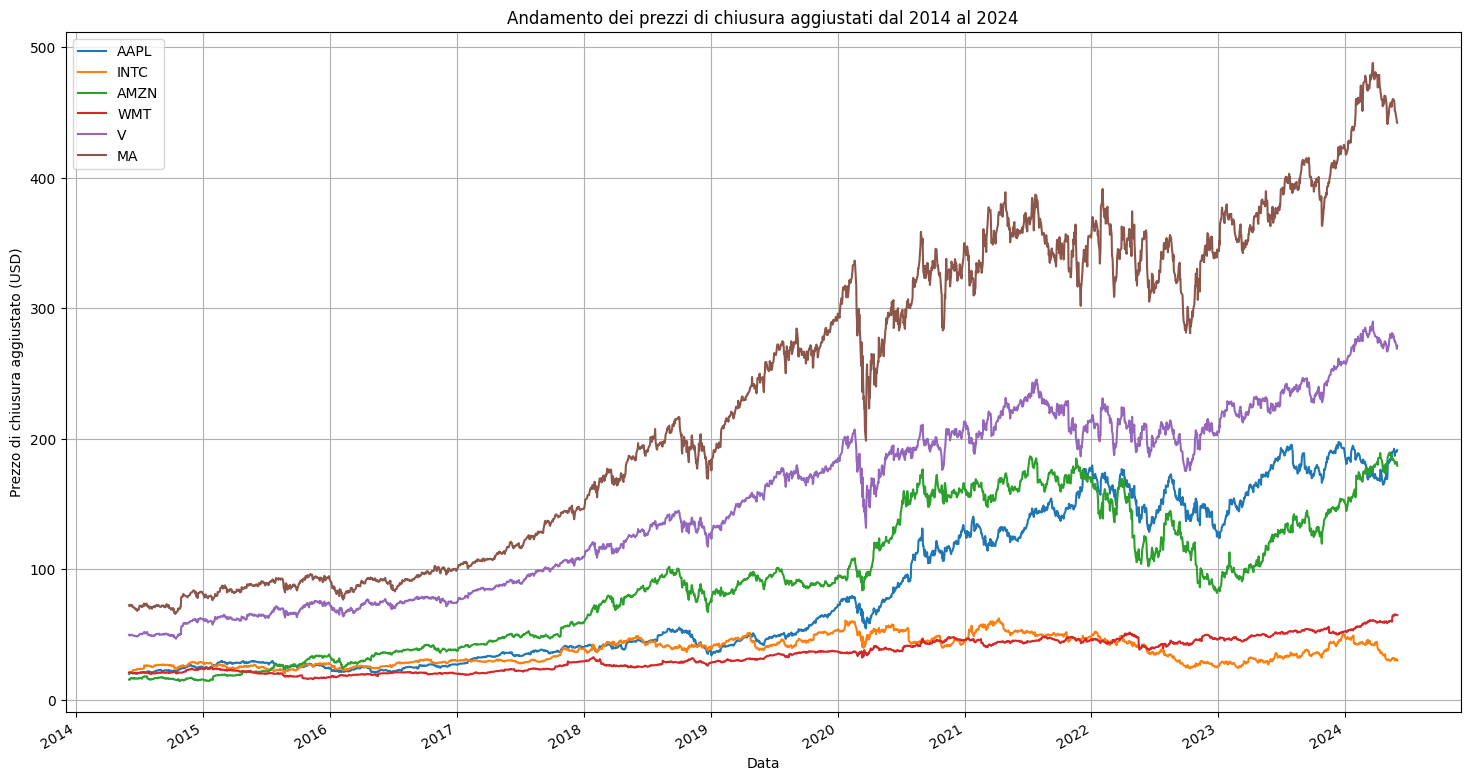

In [118]:
prezzi_chiusura_giornalieri.plot(figsize=(18, 10))
plt.title('Andamento dei prezzi di chiusura aggiustati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Prezzo di chiusura aggiustato (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Statistiche descrittive

Calcoliamo il rendimento cumulato per ciascun titolo.

In primis definiamo una funzione che ci consenta di rappresentare i grafici di ciascun titolo in maniera separata, per evitare di fare confusione.

In [119]:
# Per creare i grafici utilizzo la mappa dei colori predefinita di matplotlib: in questo modo, ogni ticker mantiene il proprio colore nei diversi grafici
mappa_colori = plt.get_cmap('tab10') 

def crea_grafici_separati(dataframe, label):
    # Numero totale di grafici
    n = len(tickers)
    
    # Calcola il numero di righe necessarie
    rows = (n + 1) // 2
    
    # Crea una griglia di sottotrame
    fig, axes = plt.subplots(rows, 2, figsize=(18, 6 * rows))
    
    # Se c'è un numero dispari di grafici, disabilita l'ultima trama vuota
    if n % 2 != 0:
        axes[-1, -1].axis('off')
    
    # Itera attraverso i tickers e genera un grafico separato per ciascuno di essi
    for i, ticker in enumerate(tickers):
        ax = axes[i // 2, i % 2]
        
        # Seleziona solo i dati relativi al ticker corrente
        data = dataframe[ticker]

        # Crea il grafico
        ax.plot(data.index, data, label=ticker, color=mappa_colori(i))  
        ax.set_title(f'{ticker}')  
        ax.set_xlabel('Data')  
        ax.set_ylabel(label) 
        ax.legend() 
        ax.grid(True)

    plt.tight_layout()
    plt.show()

A partire dal DataFrame contenente i prezzi di chiusura giornalieri andiamo a ricavare i rendimenti netti e lordi.

In [120]:
# calcolo i rendimenti netti (come variazione di prezzo giornaliera) e rimuovo i NaN
rendimenti_netti_giornalieri = prezzi_chiusura_giornalieri.pct_change().dropna()
rendimenti_netti_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014141,0.014674,-0.005343,-0.000651,-0.010304,-0.009085
2014-06-04,0.011419,-0.002169,-0.001335,0.005475,0.000521,-0.000393
2014-06-05,0.003924,0.002174,0.054730,0.002463,0.003736,0.006814
2014-06-06,-0.002750,0.018438,0.018852,-0.001423,0.003676,0.008199
2014-06-09,0.016001,-0.009230,-0.006582,-0.002590,-0.001972,-0.007874
...,...,...,...,...,...,...
2024-05-23,-0.021058,-0.042648,-0.011358,-0.006284,-0.004899,-0.011631
2024-05-24,0.016588,0.021277,-0.001657,0.008328,0.000948,-0.000066
2024-05-28,0.000053,0.011068,0.007745,-0.005200,-0.012787,-0.013520


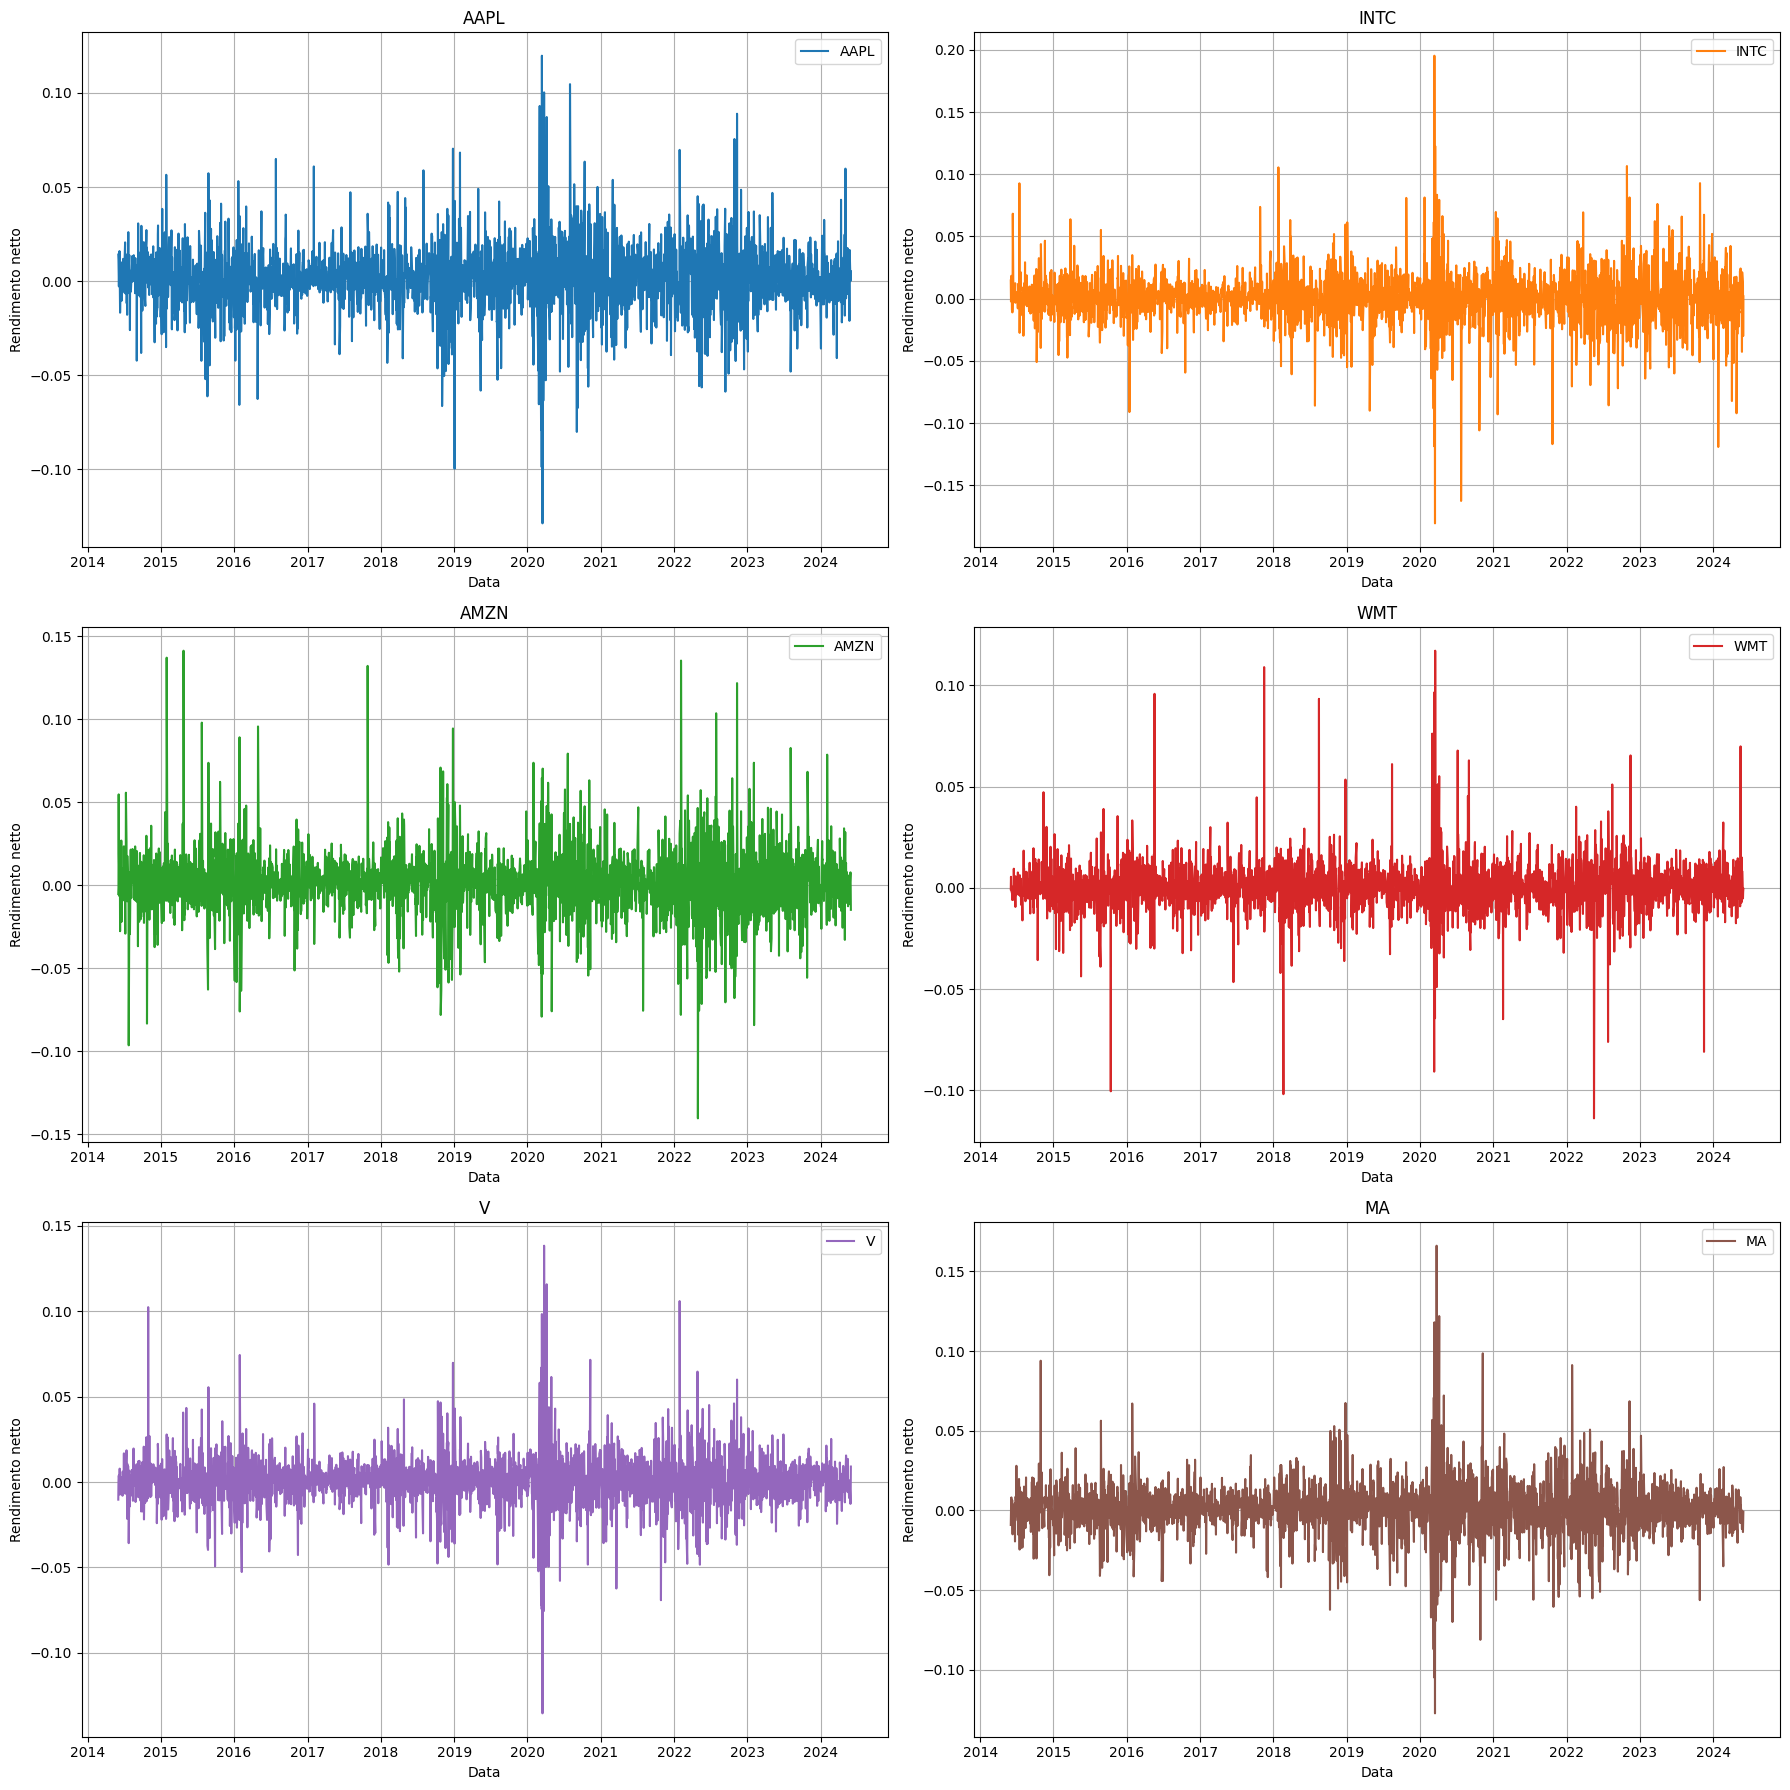

In [121]:
crea_grafici_separati(rendimenti_netti_giornalieri, 'Rendimento netto')

In [122]:
# ricavo i rendimenti lordi a partire da quelli netti
rendimenti_lordi_giornalieri = rendimenti_netti_giornalieri + 1
rendimenti_lordi_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,1.014141,1.014674,0.994657,0.999349,0.989696,0.990915
2014-06-04,1.011419,0.997831,0.998665,1.005475,1.000521,0.999607
2014-06-05,1.003924,1.002174,1.054730,1.002463,1.003736,1.006814
2014-06-06,0.997250,1.018438,1.018852,0.998577,1.003676,1.008199
2014-06-09,1.016001,0.990770,0.993418,0.997410,0.998028,0.992126
...,...,...,...,...,...,...
2024-05-23,0.978942,0.957352,0.988642,0.993716,0.995101,0.988369
2024-05-24,1.016588,1.021277,0.998343,1.008328,1.000948,0.999934
2024-05-28,1.000053,1.011068,1.007745,0.994800,0.987213,0.986480


In [123]:
# calcolo i rendimenti cumulati come prodotto cumulativo dei rendimenti lordi
rendimenti_cumulati = rendimenti_lordi_giornalieri.cumprod()

rendimenti_cumulati

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,1.014141,1.014674,0.994657,0.999349,0.989696,0.990915
2014-06-04,1.025722,1.012472,0.993330,1.004820,0.990211,0.990526
2014-06-05,1.029746,1.014674,1.047695,1.007296,0.993911,0.997275
2014-06-06,1.026915,1.033382,1.067446,1.005863,0.997564,1.005451
2014-06-09,1.043347,1.023844,1.060420,1.003257,0.995597,0.997534
...,...,...,...,...,...,...
2024-05-23,9.410155,1.448099,11.724517,3.117381,5.509321,6.228434
2024-05-24,9.566252,1.478909,11.705090,3.143343,5.514544,6.228020
2024-05-28,9.566756,1.495277,11.795751,3.126997,5.444028,6.143817


Visualizziamo l'andamento dei rendimenti cumulati nel corso del tempo.

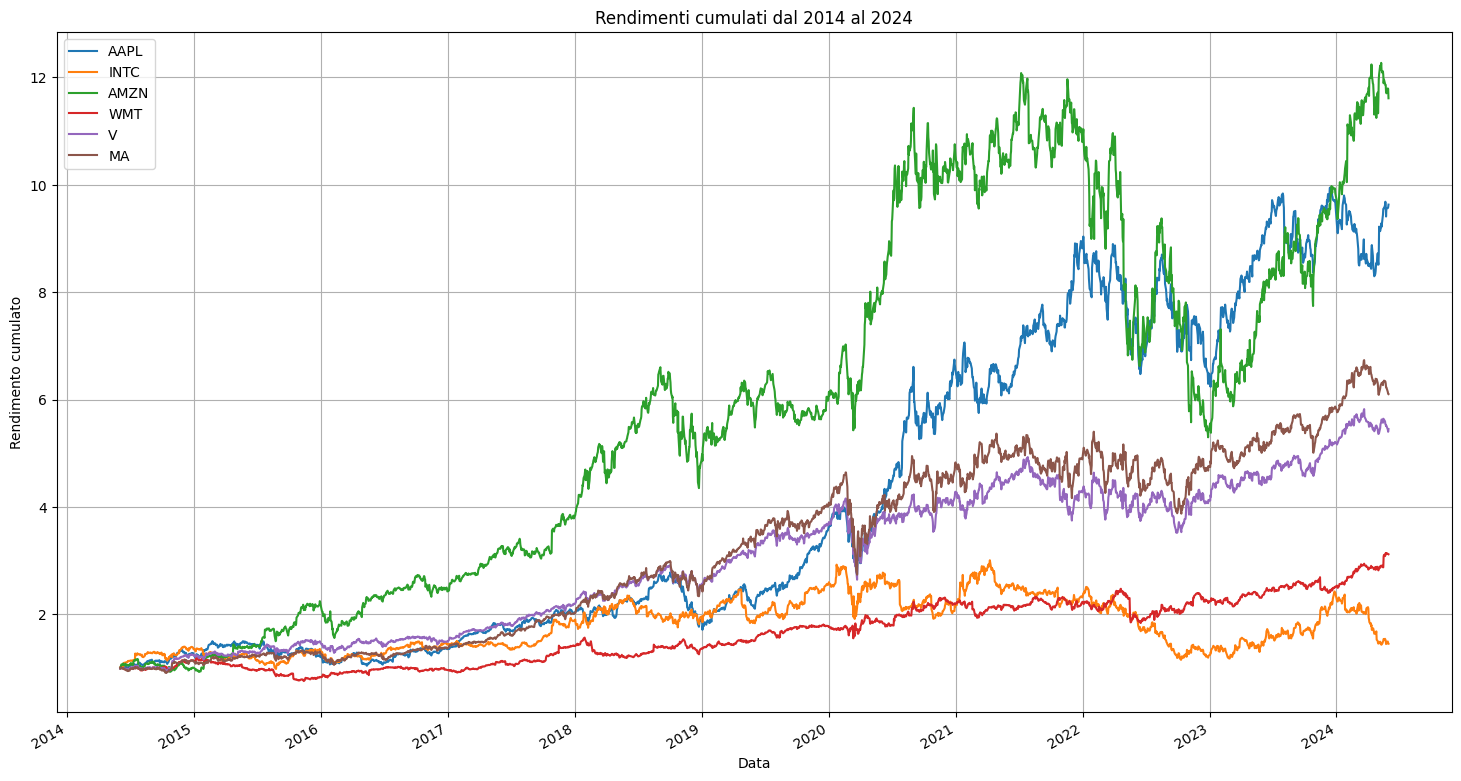

In [124]:
rendimenti_cumulati.plot(figsize=(18, 10))
plt.title('Rendimenti cumulati dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Rendimento cumulato')
plt.legend()
plt.grid(True)
plt.show()

Analogamente, visualizziamo l'evoluzione della volatilità nel tempo.

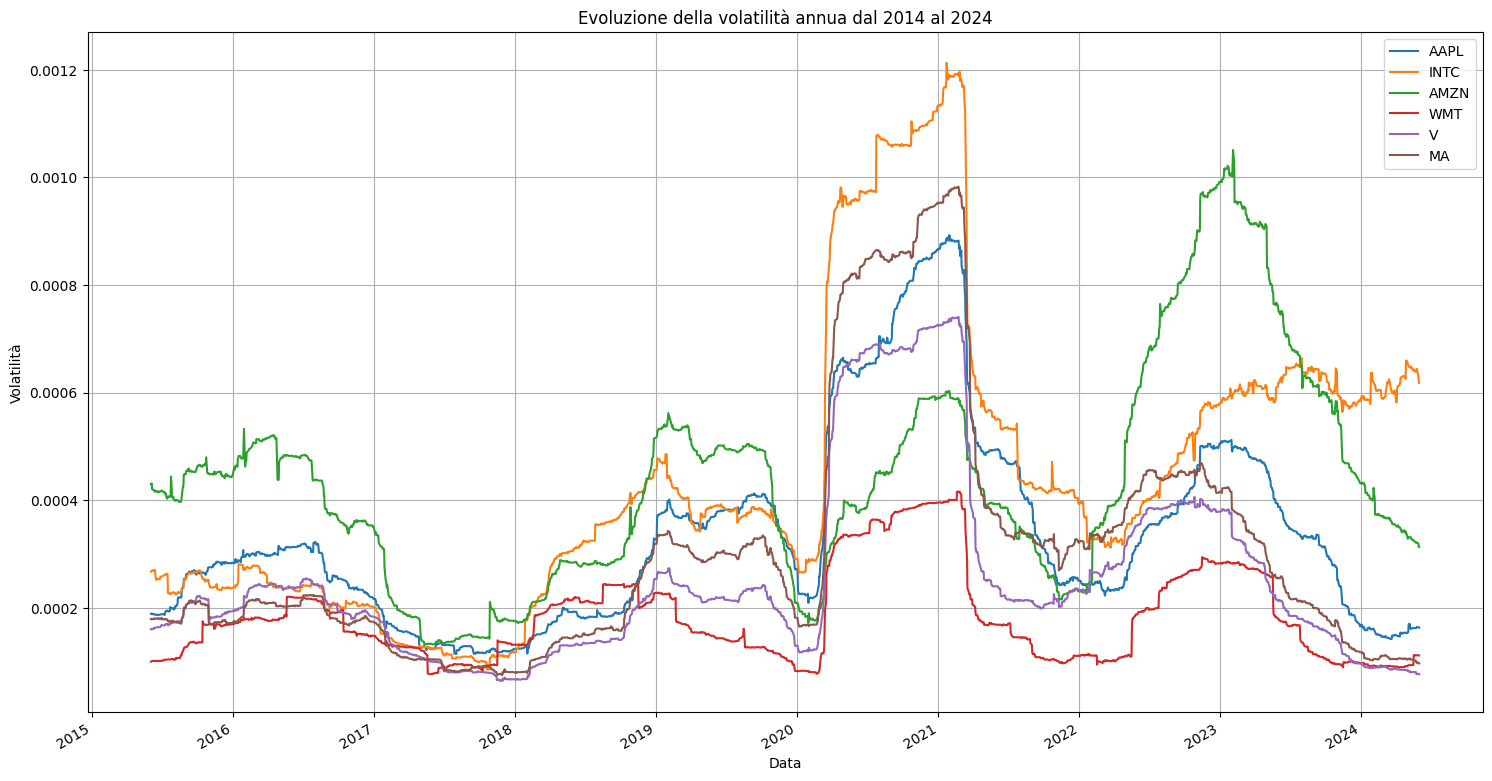

In [125]:
rendimenti_netti_giornalieri.rolling(window=252).var().plot(figsize=(18, 10))
plt.title('Evoluzione della volatilità annua dal 2014 al 2024')
plt.xlabel('Data')
plt.ylabel('Volatilità')
plt.legend()
plt.grid(True)
plt.show()

Ora calcoliamo il rendimento composto annuo sul periodo considerato (Compound Annual Growth Rate, CAGR).

In [126]:
numero_anni = (fine - inizio) / dt.timedelta(days=365)
CAGR = rendimenti_cumulati.iloc[-1] ** (1/numero_anni) - 1 # sfrutto i rendimenti cumulati che ho già calcolato
CAGR.rename("CAGR", inplace=True)

CAGR

Ticker
AAPL    0.253984
INTC    0.038066
AMZN    0.277630
WMT     0.120397
V       0.184630
MA      0.198085
Name: CAGR, dtype: float64

A partire dai rendimenti lordi giornalieri ricaviamo i rendimenti logaritmici.

In [127]:
rendimenti_logaritmici = np.log(rendimenti_lordi_giornalieri) # i rendimenti lordi li ho calcolati in precedenza
rendimenti_logaritmici

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Date,,,,,,
2014-06-03,0.014042,0.014567,-0.005357,-0.000652,-0.010357,-0.009127
2014-06-04,0.011354,-0.002172,-0.001336,0.005460,0.000521,-0.000393
2014-06-05,0.003916,0.002172,0.053285,0.002460,0.003729,0.006790
2014-06-06,-0.002754,0.018270,0.018677,-0.001424,0.003669,0.008165
2014-06-09,0.015875,-0.009273,-0.006604,-0.002594,-0.001974,-0.007905
...,...,...,...,...,...,...
2024-05-23,-0.021283,-0.043584,-0.011423,-0.006303,-0.004911,-0.011700
2024-05-24,0.016452,0.021053,-0.001658,0.008294,0.000948,-0.000066
2024-05-28,0.000053,0.011007,0.007716,-0.005214,-0.012870,-0.013612


Vediamo il livello di correlazione che sussiste tra i rendimenti dei titoli appartenenti allo stesso settore.

In [128]:
rendimenti_netti_giornalieri[tickers_settore1].corr()

Ticker,AAPL,INTC
Ticker,,
AAPL,1.000000,0.512747
INTC,0.512747,1.000000


In [129]:
rendimenti_netti_giornalieri[tickers_settore2].corr()

Ticker,AMZN,WMT
Ticker,,
AMZN,1.000000,0.250431
WMT,0.250431,1.000000


In [130]:
rendimenti_netti_giornalieri[tickers_settore3].corr()

Ticker,V,MA
Ticker,,
V,1.000000,0.895385
MA,0.895385,1.000000


Visualizziamo come i rendimenti sono distribuiti attraverso degli istogrammi. 

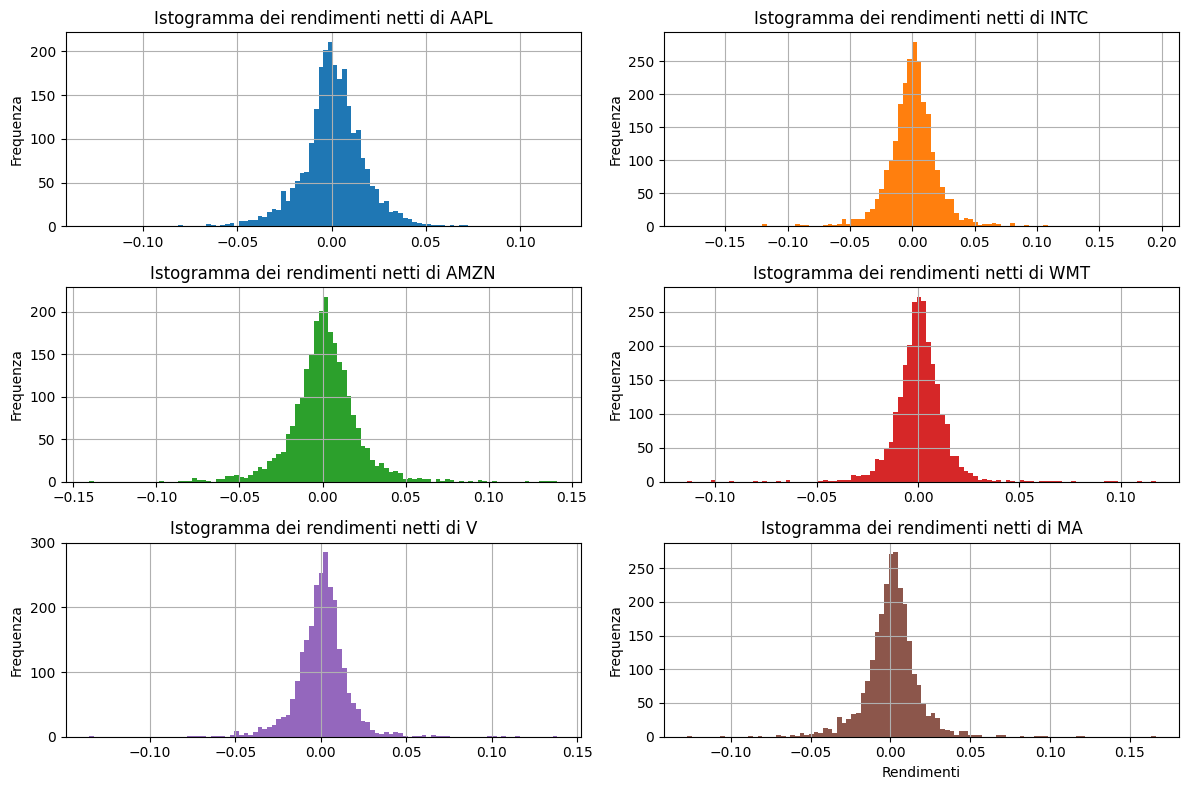

In [131]:
# Numero di colonne per la disposizione degli istogrammi
num_cols = 2
num_rows = int(len(tickers) / num_cols)

# Creazione della figura con sottotrame
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Appiattire gli assi in caso di array bidimensionale
axes = axes.flatten()

# Creazione degli istogrammi con colori personalizzati
for i, ticker in enumerate(tickers):
    color = mappa_colori(i % 10)  # Usa il modulo per assicurarsi di non superare l'indice dei colori disponibili
    rendimenti_netti_giornalieri[ticker].hist(bins=100, ax=axes[i], color=color)
    axes[i].set_title(f'Istogramma dei rendimenti netti di {ticker}')
    axes[i].set_ylabel('Frequenza')

# Rimuovere assi vuoti
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.xlabel('Rendimenti')
plt.tight_layout()
plt.show()

Per ciascun titolo visualizziamo i grafici diagnostici a tre sezioni.

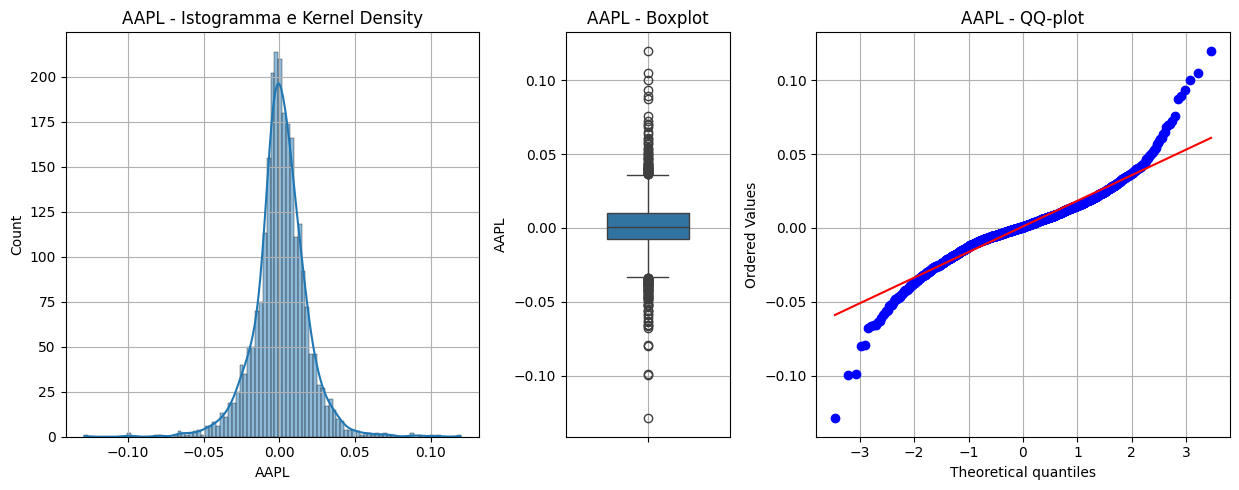

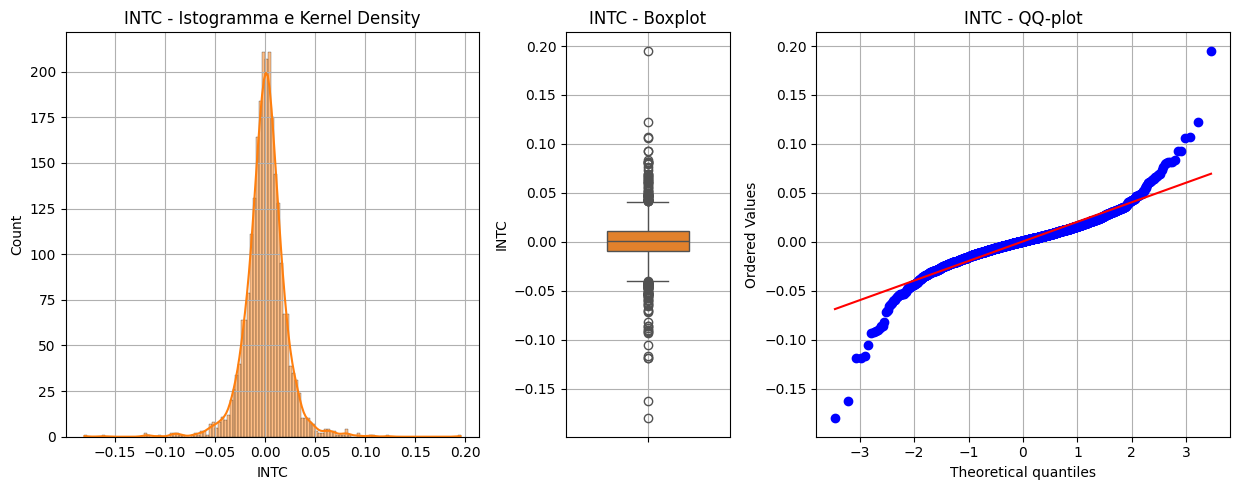

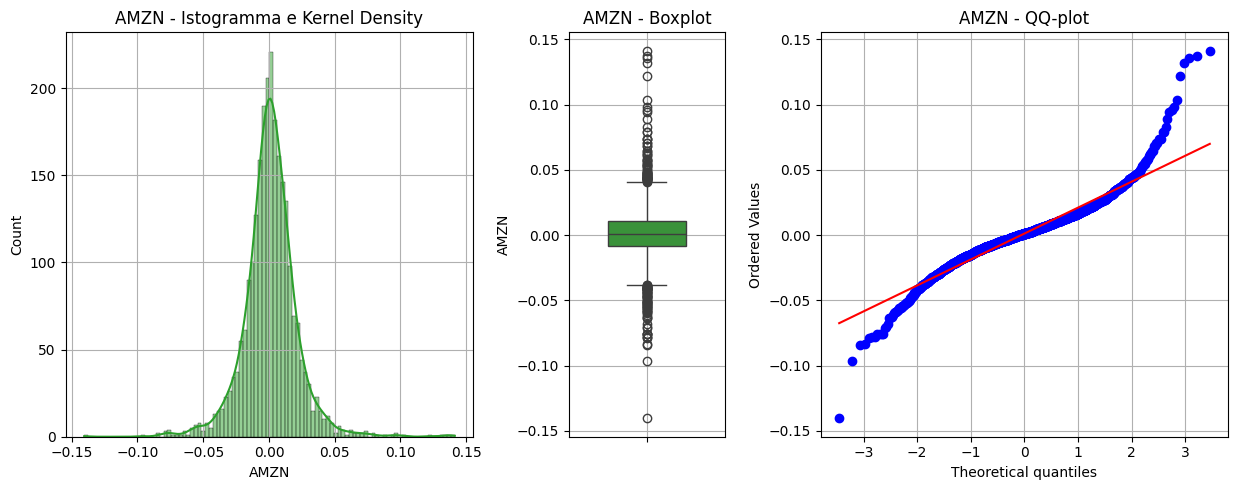

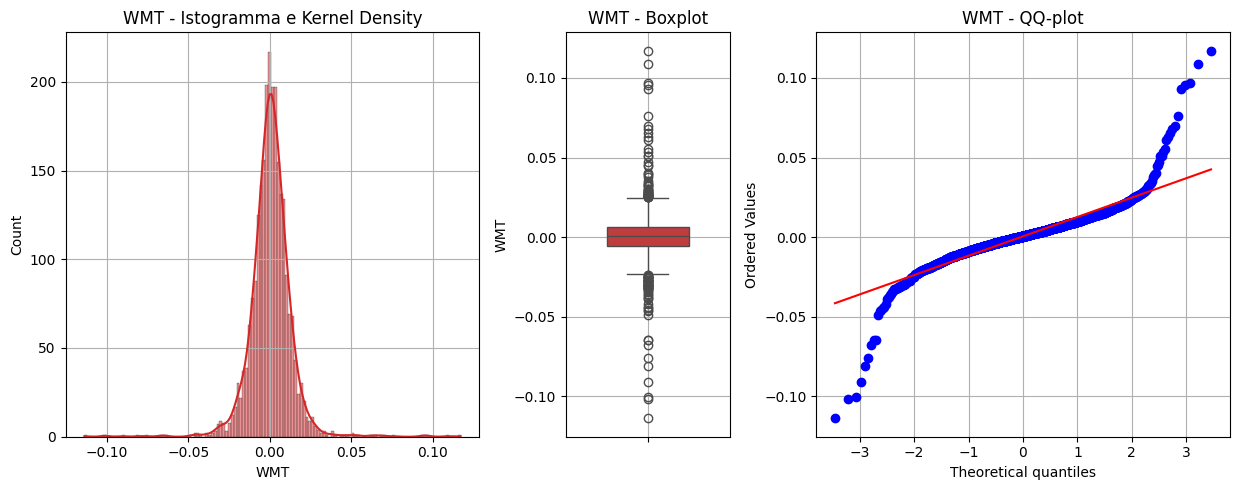

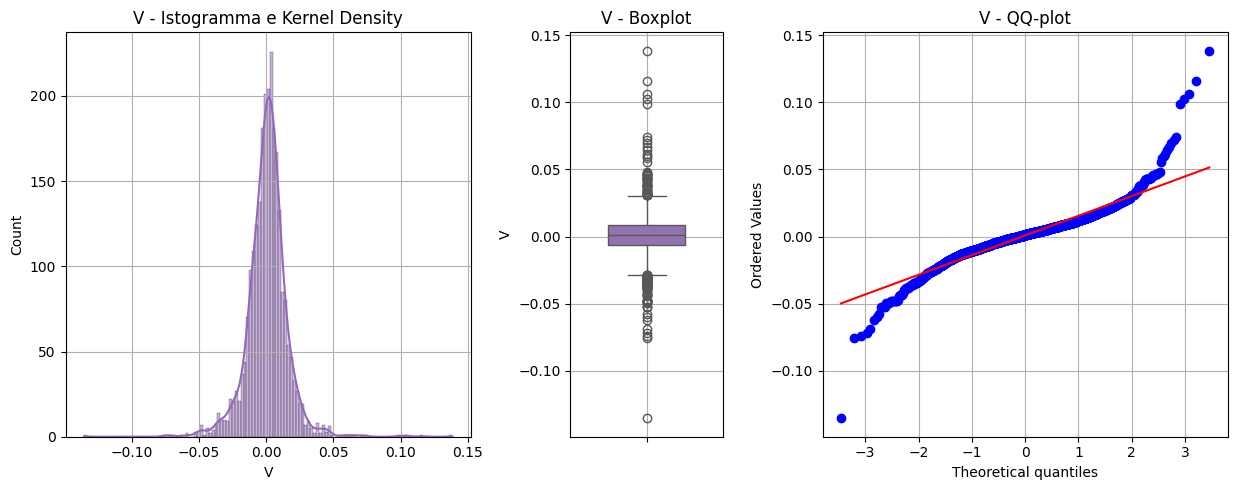

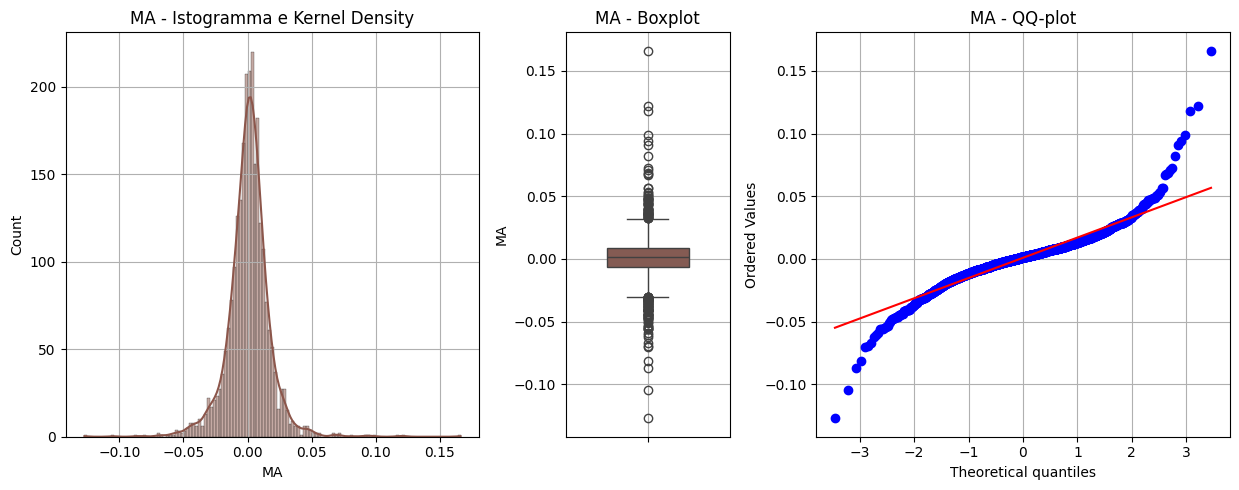

In [132]:
def crea_grafici_diagnostici(dataframe, ticker, colore):
    plt.figure(figsize=(15, 5))

    # Istogramma e kernel density
    plt.subplot2grid((1, 6), (0, 0), colspan=2, rowspan=1)
    sns.histplot(data=dataframe[ticker], kde=True, color=colore)
    plt.title(f'{ticker} - Istogramma e Kernel Density')
    plt.grid(True)

    # Boxplot
    plt.subplot2grid((1, 6), (0, 2), colspan=1, rowspan=1)
    sns.boxplot(data=dataframe[ticker], color=colore, width=0.5)
    plt.title(f'{ticker} - Boxplot')
    plt.grid(True)

    # QQ-plot
    plt.subplot2grid((1, 6), (0, 3), colspan=2, rowspan=1)
    stats.probplot(dataframe[ticker], dist="norm", plot=plt)
    plt.title(f'{ticker} - QQ-plot')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Esegui la funzione per ciascun titolo
for i, ticker in enumerate(tickers):
    colore = mappa_colori(i % 10)  # L'operazione modulo assicura che non superiamo l'indice massimo della mappa
    crea_grafici_diagnostici(rendimenti_netti_giornalieri, ticker, colore)

Calcoliamo le statistiche descrittive univariate dei rendimenti netti giornalieri.

In [133]:
statistiche_rendimenti_netti_giornalieri = rendimenti_netti_giornalieri.describe()

varianza = pd.Series(rendimenti_netti_giornalieri.var()).to_frame().T
kurtosi = pd.Series(rendimenti_netti_giornalieri.kurtosis()).to_frame().T
skewness = pd.Series(rendimenti_netti_giornalieri.skew()).to_frame().T
varianza.rename(index={0: 'var'}, inplace=True)
kurtosi.rename(index={0: 'kurt'}, inplace=True)
skewness.rename(index={0: 'skew'}, inplace=True)

statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, varianza])
statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, kurtosi])
statistiche_rendimenti_netti_giornalieri = pd.concat([statistiche_rendimenti_netti_giornalieri, skewness])

statistiche_rendimenti_netti_giornalieri

Ticker,AAPL,INTC,AMZN,WMT,V,MA
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,0.001060,0.000371,0.001187,0.000539,0.000793,0.000863
std,0.017841,0.021047,0.020638,0.013181,0.015427,0.016970
min,-0.128647,-0.180415,-0.140494,-0.113758,-0.135472,-0.127255
25%,-0.007315,-0.009571,-0.008609,-0.005382,-0.006481,-0.006842
50%,0.000821,0.000795,0.001153,0.000576,0.001316,0.001395
75%,0.010141,0.010663,0.011145,0.006607,0.008235,0.008719
max,0.119808,0.195213,0.141311,0.117085,0.138426,0.166109
var,0.000318,0.000443,0.000426,0.000174,0.000238,0.000288
kurt,5.360847,10.310482,6.337522,16.261147,10.399195,10.021956


Ora vediamo la matrice di covarianza e la matrice di correlazione.

In [134]:
rendimenti_netti_giornalieri.cov() # matrice di covarianza

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Ticker,,,,,,
AAPL,0.000318,0.000193,0.000203,0.000075,0.000158,0.000178
INTC,0.000193,0.000443,0.000173,0.000076,0.000150,0.000169
AMZN,0.000203,0.000173,0.000426,0.000068,0.000149,0.000169
WMT,0.000075,0.000076,0.000068,0.000174,0.000059,0.000064
V,0.000158,0.000150,0.000149,0.000059,0.000238,0.000234
MA,0.000178,0.000169,0.000169,0.000064,0.000234,0.000288


In [135]:
rendimenti_netti_giornalieri.corr() # matrice di correlazione

Ticker,AAPL,INTC,AMZN,WMT,V,MA
Ticker,,,,,,
AAPL,1.000000,0.512747,0.551232,0.320545,0.572280,0.586874
INTC,0.512747,1.000000,0.397293,0.274460,0.461214,0.474269
AMZN,0.551232,0.397293,1.000000,0.250431,0.466580,0.483197
WMT,0.320545,0.274460,0.250431,1.000000,0.289393,0.284193
V,0.572280,0.461214,0.466580,0.289393,1.000000,0.895385
MA,0.586874,0.474269,0.483197,0.284193,0.895385,1.000000


Vediamo com'è stato l'andamento nel tempo della correlazione tra titoli dello stesso settore.

In [136]:
def andamento_correlazione_rendimenti(tickers_settore, nome_settore, colore):
    # Calcola la correlazione tra i titoli del settore
    correlazione = rendimenti_netti_giornalieri[tickers_settore[0]].rolling(window=252).corr(rendimenti_netti_giornalieri[tickers_settore[1]])

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    correlazione.plot(label=nome_settore, ax=ax, color=colore)

    ax.axhline(rendimenti_netti_giornalieri.corr().loc[tickers_settore[0], tickers_settore[1]], c='r')
    plt.legend()
    plt.title(f'Andamento della correlazione nel tempo dei titoli per il settore {nome_settore}')
    plt.xlabel('Data')
    plt.ylabel('Correlazione')
    plt.grid(True)
    plt.show()

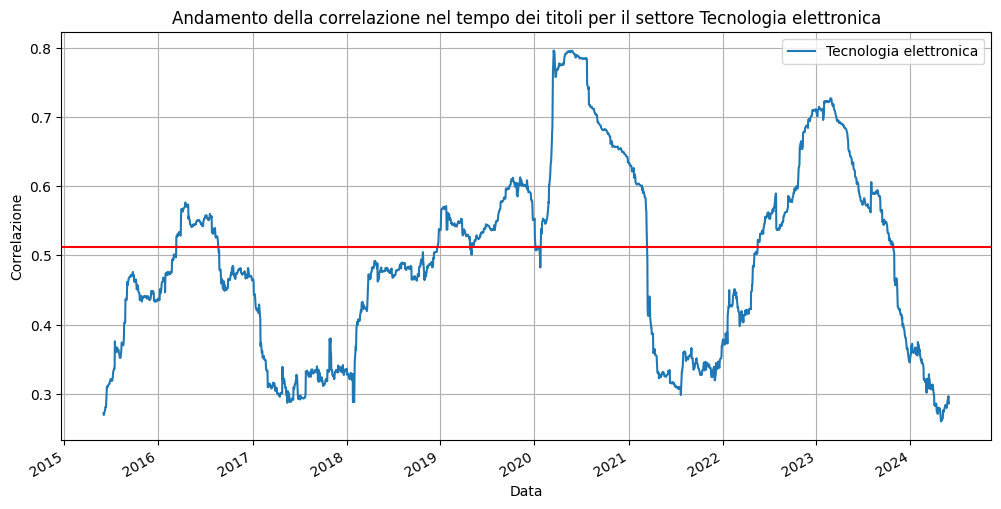

In [137]:
andamento_correlazione_rendimenti(tickers_settore1, settore_1, mappa_colori(0))

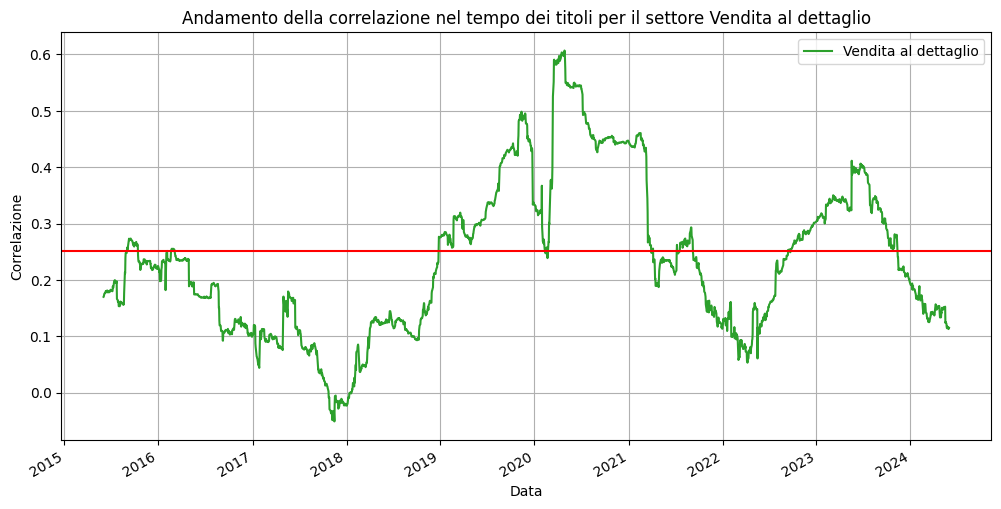

In [138]:
andamento_correlazione_rendimenti(tickers_settore2, settore_2, mappa_colori(2))

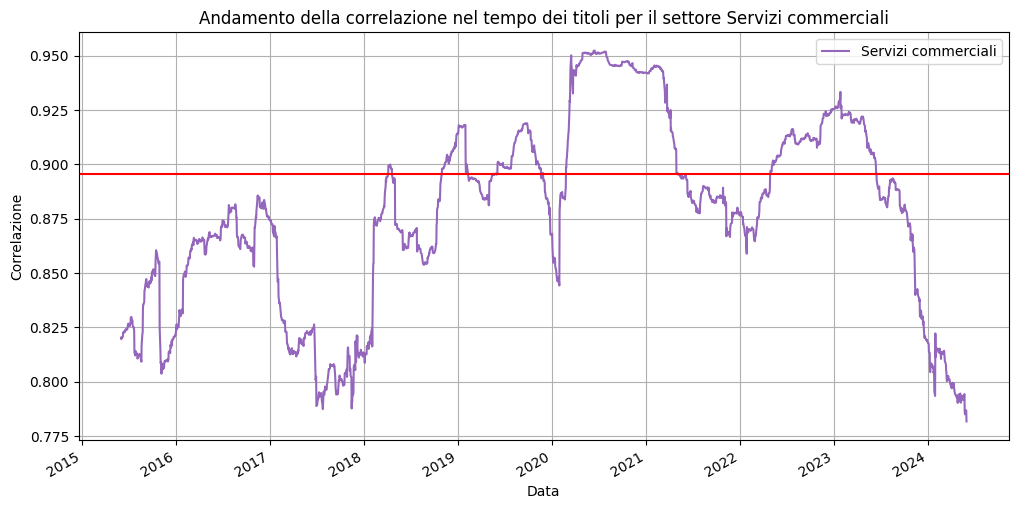

In [139]:
andamento_correlazione_rendimenti(tickers_settore3, settore_3, mappa_colori(4))

Attraverso degli scatter plot osserviamo la dispersione dei rendimenti mettendo a confronto i titoli dello stesso settore. 

In [140]:
colore_neutro_chiaro = '#333333'
colore_neutro_scuro = '#666666'
def crea_scatter_plot(dataframe, settore):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(dataframe[settore[0]], dataframe[settore[1]], color=colore_neutro_chiaro)
    ax.set_xlim(min(dataframe[settore[0]]), max(dataframe[settore[1]]))
    ax.autoscale(False)
    ax.vlines(0, -10, 10, color=colore_neutro_scuro)
    ax.hlines(0, -10, 10, color=colore_neutro_scuro)
    ax.plot((-10,10),(-10,10), color=colore_neutro_scuro)
    ax.set_xlabel(settore[0])
    ax.set_ylabel(settore[1])
    plt.grid(True)

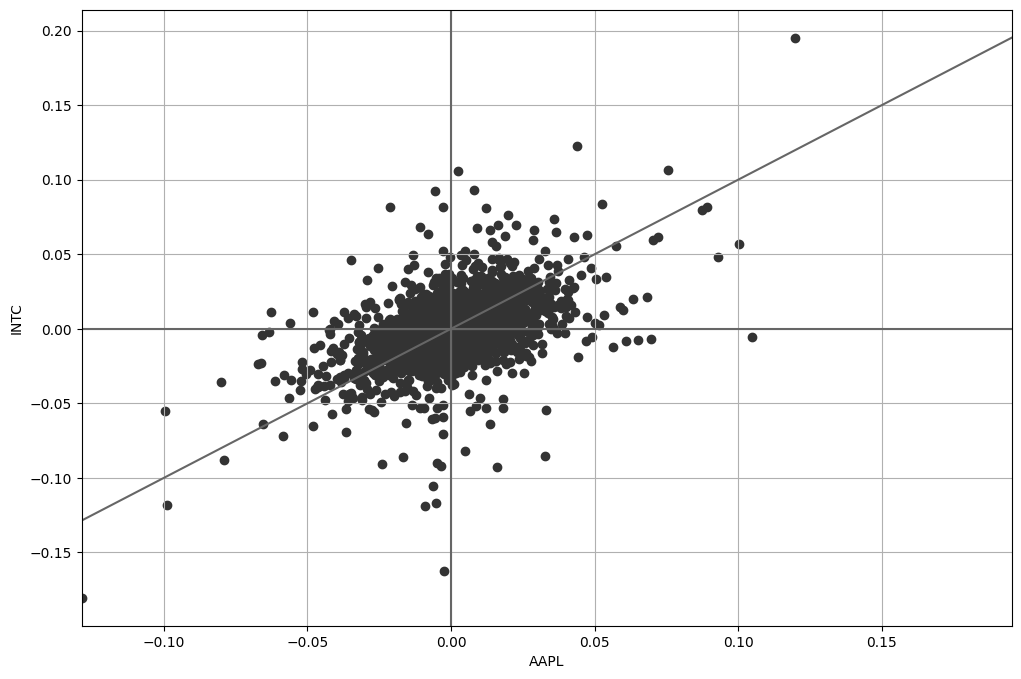

In [141]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore1)

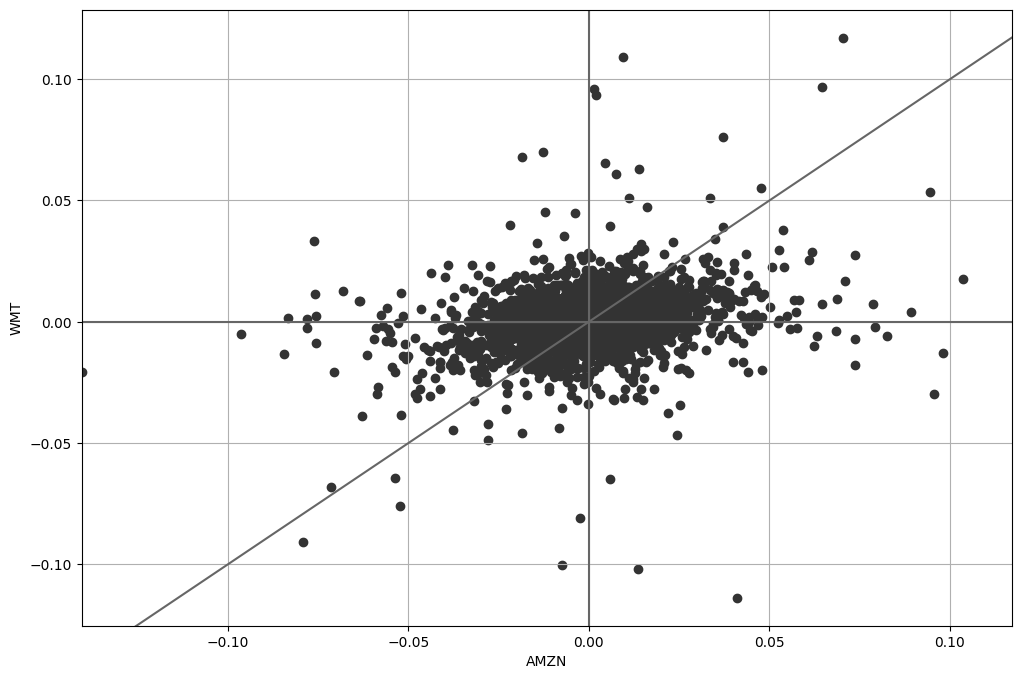

In [142]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore2)

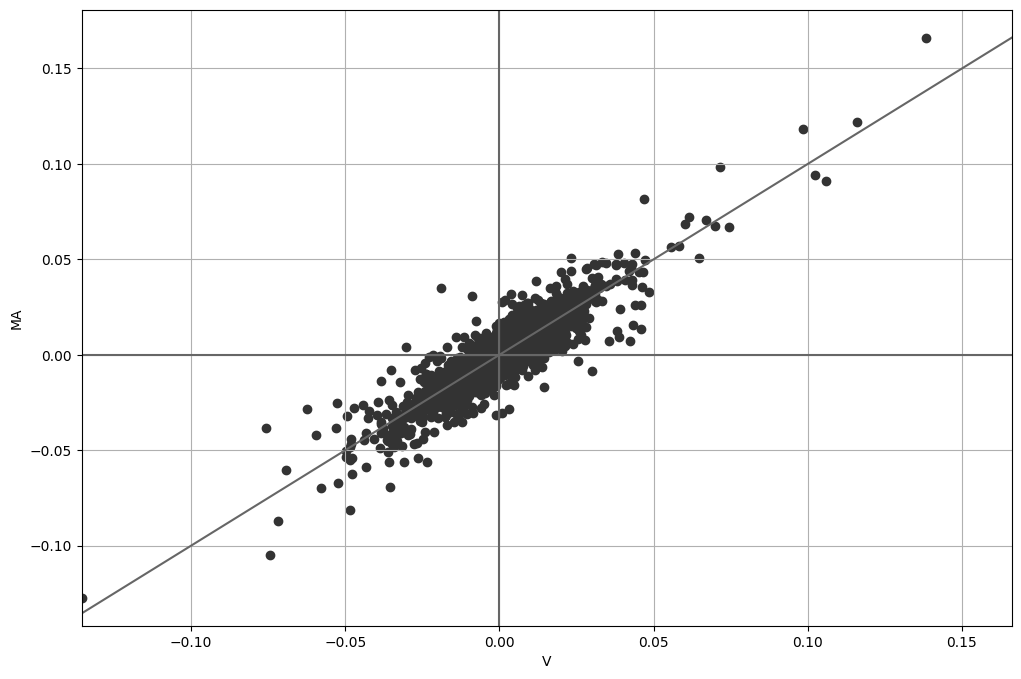

In [143]:
crea_scatter_plot(rendimenti_netti_giornalieri, tickers_settore3)

## Strategie di trading e backtesting

Procediamo ora con la costruzione di una strategia di trading. <br>
L'idea che si vuole analizzare è quella di combinare l'utilizzo delle medie mobili esponenziali e dell'indice RSI per generare segnali d'acquisto: utilizzando entrambi gli indicatori è possibile tenere conto sia del trend (catturato dalle medie mobili esponenziali) sia del momentum (catturato dall'indice RSI).

In [144]:
ticker_strategia = 'MA'
indicatori_trading  = prezzi_chiusura_giornalieri[ticker_strategia].copy()
indicatori_trading.rename('Chiusura aggiustata', inplace=True)
indicatori_trading = indicatori_trading.to_frame()

indicatori_trading['EMA20'] = indicatori_trading['Chiusura aggiustata'].ewm(span=20, adjust=False).mean() # calcolo la media mobile esponenziale a 20 giorni
indicatori_trading['EMA50'] = indicatori_trading['Chiusura aggiustata'].ewm(span=50, adjust=False).mean() # calcolo la media mobile esponenziale a 50 giorni

In [145]:
def calcola_RSI(data, window=14):
    delta = data['Chiusura aggiustata'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

indicatori_trading['RSI'] = calcola_RSI(indicatori_trading) # calcolo l'indice RSI
indicatori_trading.dropna(inplace=True)

indicatori_trading

,Chiusura aggiustata,EMA20,EMA50,RSI
Date,,,,
2014-06-19,69.829765,71.584136,72.034416,29.558614
2014-06-20,69.397263,71.375863,71.930998,27.685722
2014-06-23,69.707520,71.216973,71.843803,33.961971
2014-06-24,68.353653,70.944276,71.706935,28.192624
2014-06-25,68.673325,70.727995,71.587969,26.600697
...,...,...,...,...
2024-05-23,451.209991,456.752035,458.953742,61.606337
2024-05-24,451.179993,456.221364,458.648889,53.338249
2024-05-28,445.079987,455.160281,458.116776,36.483716


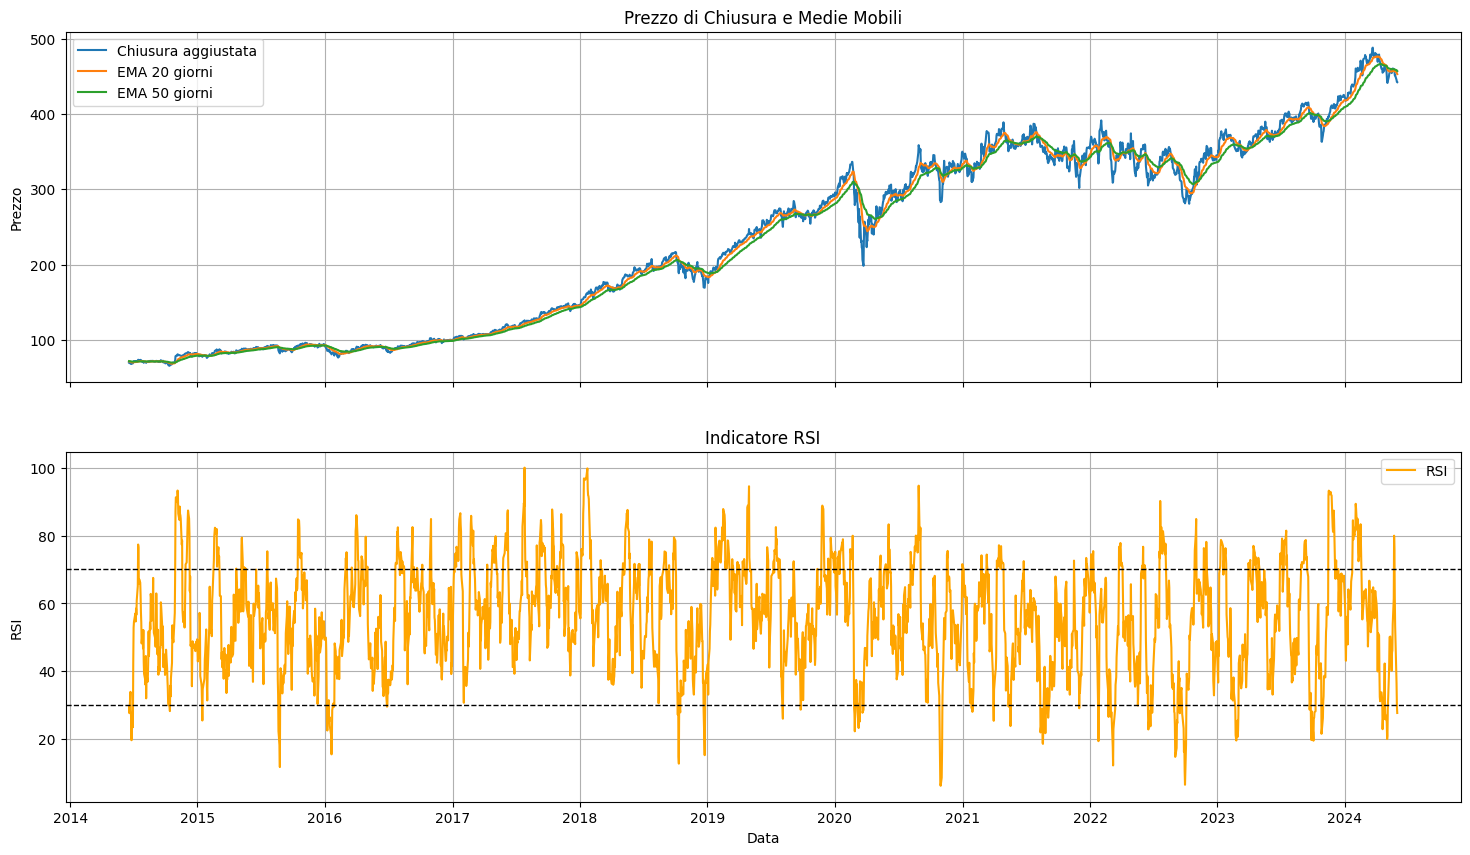

In [146]:
# Creazione dei grafici
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Grafico del prezzo di chiusura e delle medie mobili
ax1.plot(indicatori_trading.index, indicatori_trading['Chiusura aggiustata'], label='Chiusura aggiustata')
ax1.plot(indicatori_trading.index, indicatori_trading['EMA20'], label='EMA 20 giorni')
ax1.plot(indicatori_trading.index, indicatori_trading['EMA50'], label='EMA 50 giorni')
ax1.set_title('Prezzo di Chiusura e Medie Mobili')
ax1.set_ylabel('Prezzo')
ax1.legend()
ax1.grid(True)

# Grafico dell'indicatore RSI
ax2.plot(indicatori_trading.index, indicatori_trading['RSI'], label='RSI', color='orange')
ax2.axhline(70, color='black', linestyle='--', linewidth=1)
ax2.axhline(30, color='black', linestyle='--', linewidth=1)
ax2.set_title('Indicatore RSI')
ax2.set_ylabel('RSI')
ax2.set_xlabel('Data')
ax2.legend()
ax2.grid(True)

plt.show()

Dopo aver calcolato gli indicatori di cui abbiamo bisogno, procediamo con l'applicazione della strategia.

Secondo la strategia viene generato un __segnale di acquisto__ quando le seguenti condizioni sono soddisfatte:
- la media mobile esponenziale a breve termine (20 giorni) sorpassa dal basso verso l'alto la media mobile esponenziale a lungo termine (50 giorni), testimoniando un trend al rialzo
- l'indice RSI supera 50, confermando che il trend rialzista è abbastanza intenso

Secondo la strategia viene generato un __segnale di vendita__ quando le seguenti condizioni sono soddisfatte:
- la media mobile esponenziale a breve termine (20 giorni) sorpassa dall'alto verso il basso la media mobile esponenziale a lungo termine (50 giorni), testimoniando un trend al ribasso
- l'indice RSI scende sotto 50, confermando che il trend ribassista è abbastanza intenso

In [147]:
strategia_trading = indicatori_trading.copy()

condizione_acquisto = ((strategia_trading['EMA20'] > strategia_trading['EMA50']) &
                       (strategia_trading['RSI'] > 50))
                      
condizione_vendita = ((strategia_trading['EMA20'] < strategia_trading['EMA50']) &
                      (strategia_trading['RSI'] < 50))

# Crea la colonna "Posizione" e assegna i valori in base alle condizioni
strategia_trading['Posizione'] = 0  # Inizializza tutte le posizioni a 0

# Imposta le posizioni a 1 quando si verifica la condizione di acquisto
strategia_trading.loc[condizione_acquisto, 'Posizione'] = 1

# Imposta le posizioni a 1 quando si verifica la condizione di vendita
strategia_trading.loc[condizione_vendita, 'Posizione'] = 0

strategia_trading

,Chiusura aggiustata,EMA20,EMA50,RSI,Posizione
Date,,,,,
2014-06-19,69.829765,71.584136,72.034416,29.558614,0
2014-06-20,69.397263,71.375863,71.930998,27.685722,0
2014-06-23,69.707520,71.216973,71.843803,33.961971,0
2014-06-24,68.353653,70.944276,71.706935,28.192624,0
2014-06-25,68.673325,70.727995,71.587969,26.600697,0
...,...,...,...,...,...
2024-05-23,451.209991,456.752035,458.953742,61.606337,0
2024-05-24,451.179993,456.221364,458.648889,53.338249,0
2024-05-28,445.079987,455.160281,458.116776,36.483716,0


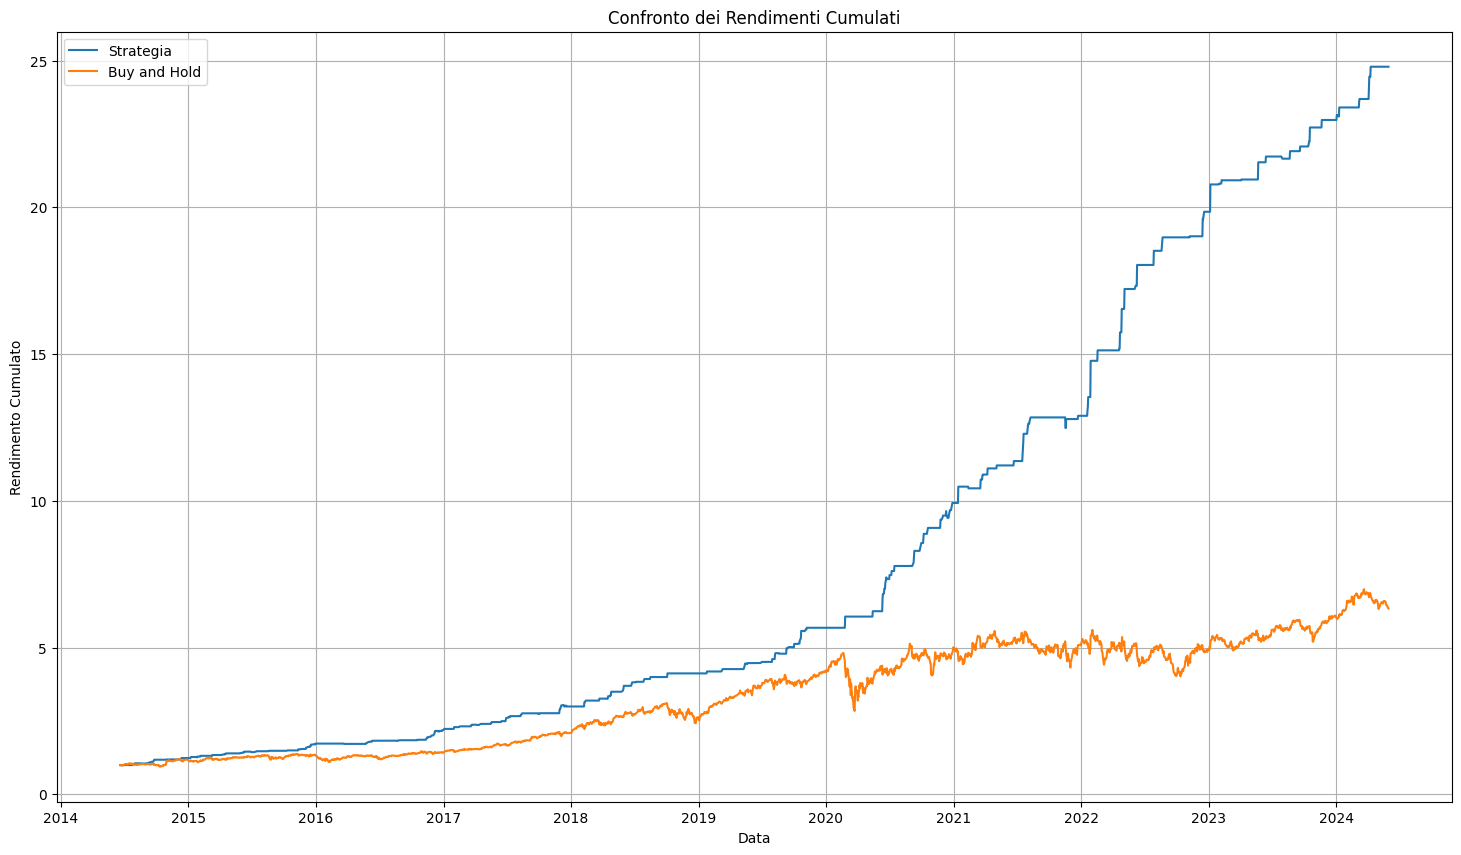

In [152]:
# Calcola i rendimenti cumulati delle due strategie # TODO: STRATEGIA DI CALCOLO DI CHATGPT
rendimenti_cumulati = (1 + strategia_trading['Posizione'].diff() * strategia_trading['Chiusura aggiustata'].pct_change()).cumprod()
rendimento_cumulato_buy_and_hold = (1 + strategia_trading['Chiusura aggiustata'].pct_change()).cumprod()

# Crea un grafico
plt.figure(figsize=(18, 10))
plt.plot(rendimenti_cumulati, label='Strategia')
plt.plot(rendimento_cumulato_buy_and_hold, label='Buy and Hold')
plt.title('Confronto dei Rendimenti Cumulati')
plt.xlabel('Data')
plt.ylabel('Rendimento Cumulato')
plt.legend()
plt.grid(True)
plt.show()

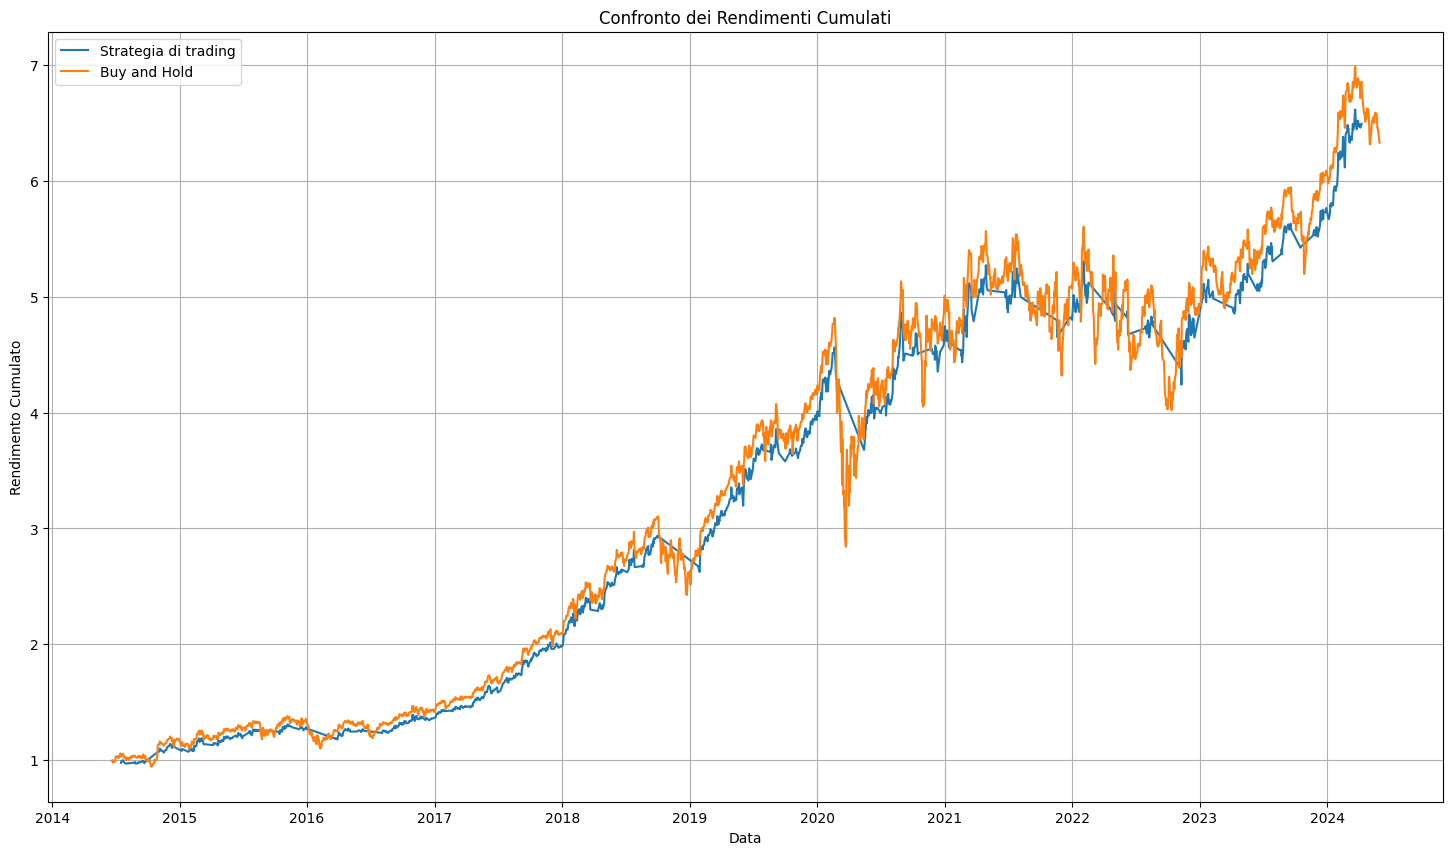

In [149]:
# TODO: STRATEGIA DI CALCOLO DEL PROF

risultati_strategia_trading = strategia_trading[strategia_trading['Posizione'] == 1].copy()
risultati_strategia_trading['Rendimento cumulato'] = np.cumprod(risultati_strategia_trading['Chiusura aggiustata'] /
                                                                risultati_strategia_trading['Chiusura aggiustata'].shift(1))
# Crea un grafico
plt.figure(figsize=(18, 10))
plt.plot(risultati_strategia_trading['Rendimento cumulato'], label='Strategia di trading')
plt.plot(rendimento_cumulato_buy_and_hold, label='Buy and Hold')
plt.title('Confronto dei Rendimenti Cumulati')
plt.xlabel('Data')
plt.ylabel('Rendimento Cumulato')
plt.legend()
plt.grid(True)
plt.show()

## CAPM

Arriviamo quindi alla sezione dedicata al Capital Asset Pricing Model.

Per prima cosa scarichiamo i dati relativi al mercato (indice S&P500).

In [153]:
# scarichiamo da yahoo finance i prezzi di chiusura dell'indice S&P500
sp500 = prendi_dati_titolo('^GSPC', inizio, fine)
sp500.drop(['Open','High','Low','Close','Volume'], axis=1, inplace=True)
sp500.rename(columns={'Adj Close': 'Chiusura aggiustata'}, inplace=True)

# ricampioniamo i prezzi su base mensile (prendendo l'ultimo giorno di ciascun mese)
sp500 = sp500.resample("ME").last()

sp500

,Chiusura aggiustata
Date,
2014-06-30,1960.229980
2014-07-31,1930.670044
2014-08-31,2003.369995
2014-09-30,1972.290039
2014-10-31,2018.050049
...,...
2024-01-31,4845.649902
2024-02-29,5096.270020
2024-03-31,5254.350098


In [155]:
sp500['Rendimenti netti mensili'] = sp500['Chiusura aggiustata'].pct_change()
sp500.dropna(inplace=True)

sp500

,Chiusura aggiustata,Rendimenti netti mensili
Date,,
2014-07-31,1930.670044,-0.015080
2014-08-31,2003.369995,0.037655
2014-09-30,1972.290039,-0.015514
2014-10-31,2018.050049,0.023201
2014-11-30,2067.560059,0.024534
...,...,...
2024-01-31,4845.649902,0.015896
2024-02-29,5096.270020,0.051721
2024-03-31,5254.350098,0.031019


In [160]:
# popoliamo un dataframe con i dati di fama e french mensili
fama_french_mensili = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
fama_french_mensili.rename({'date_ff_factors': 'Date'}, axis=1, inplace=True)
fama_french_mensili.set_index('Date', inplace = True)
fama_french_mensili = fama_french_mensili.loc[inizio : fine] # filtriamo per il periodo di interesse

fama_french_mensili

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-05-31,0.0206,-0.0188,-0.0013,0.0000
2014-06-30,0.0261,0.0309,-0.0070,0.0000
2014-07-31,-0.0204,-0.0429,0.0003,0.0000
2014-08-31,0.0424,0.0040,-0.0045,0.0000
2014-09-30,-0.0197,-0.0371,-0.0134,0.0000
...,...,...,...,...
2023-12-31,0.0487,0.0634,0.0493,0.0043
2024-01-31,0.0070,-0.0509,-0.0238,0.0047
2024-02-29,0.0506,-0.0024,-0.0349,0.0042


In [175]:
dataframe_capm = dataframe_completo.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
dataframe_capm.rename(columns={'Adj Close': 'Chiusura aggiustata'}, inplace=True)

# trasformiamo le date in oggetti datetime facilmente manipolabili da pandas
dataframe_capm.index = dataframe_capm.index.set_levels(pd.to_datetime(dataframe_capm.index.levels[1]), level=1)

# per ciascun ticker, ricampioniamo il dataframe su base mensile
dataframe_capm = dataframe_capm.groupby('Ticker').resample('ME', level=1).last()

# calcoliamo il rendimento netto mensile
dataframe_capm['Rendimento netto mensile'] = dataframe_capm.groupby('Ticker')['Chiusura aggiustata'].pct_change()
dataframe_capm = dataframe_capm.dropna()

dataframe_capm

Chiusura aggiustata  Rendimento netto mensile
Ticker Date                                                     
AAPL   2014-07-31            21.140390                  0.028731
       2014-08-31            22.778957                  0.077509
       2014-09-30            22.390055                 -0.017073
       2014-10-31            24.001244                  0.071960
       2014-11-30            26.544867                  0.105979
...                                ...                       ...
WMT    2024-01-31            54.707005                  0.048208
       2024-02-29            58.209579                  0.064024
       2024-03-31            59.962444                  0.030113
       2024-04-30            59.145275                 -0.013628
       2024-05-31            64.889999                  0.097129

[714 rows x 2 columns]

In [177]:
dataframe_capm['Eccesso di ritorno mensile'] = dataframe_capm['Rendimento netto mensile'] - fama_french_mensili['RF']

dataframe_capm

Chiusura aggiustata  Rendimento netto mensile  \
Ticker Date                                                        
AAPL   2014-07-31            21.140390                  0.028731   
       2014-08-31            22.778957                  0.077509   
       2014-09-30            22.390055                 -0.017073   
       2014-10-31            24.001244                  0.071960   
       2014-11-30            26.544867                  0.105979   
...                                ...                       ...   
WMT    2024-01-31            54.707005                  0.048208   
       2024-02-29            58.209579                  0.064024   
       2024-03-31            59.962444                  0.030113   
       2024-04-30            59.145275                 -0.013628   
       2024-05-31            64.889999                  0.097129   

                   Eccesso di ritorno rispetto al mercato  \
Ticker Date                                                 
AAPL   2014-07-31                                0.028731   
       2014-08-31                                0.077509   
       2014-09-30                               -0.017073   
       2014-10-31                                0.071960   
       2014-11-30                                0.105979   
...                                                   ...   
WMT    2024-01-31                                0.043508   
       2024-02-29                                0.059824   
       2024-03-31                                0.025813   
       2024-04-30                               -0.018328   
       2024-05-31                                     NaN   

                   Eccesso di ritorno mensile  
Ticker Date                                    
AAPL   2014-07-31                    0.028731  
       2014-08-31                    0.077509  
       2014-09-30                   -0.017073  
       2014-10-31                    0.071960  
       2014-11-30                    0.105979  
...                                       ...  
WMT    2024-01-31                    0.043508  
       2024-02-29                    0.059824  
       2024-03-31                    0.025813  
       2024-04-30                   -0.018328  
       2024-05-31                         NaN  

[714 rows x 4 columns]